# Diabetic Retinopathy Detection

In [1]:
# Data science libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Keras API libraries
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Flatten

from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as k

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Get the path for Dataset 
csv_path = '/content/drive/MyDrive/diabetic_retinopathy/trainLabels.csv'
img_path = '/content/drive/MyDrive/diabetic_retinopathy/dataset'

In [4]:
#Load labels dataset
df_train = pd.read_csv(csv_path)

##Shape of the dataset
df_train.shape

(1427, 2)

In [5]:
df_train.head()

,image,level
0,84_left,0
1,84_right,0
2,95_left,0
3,95_right,0
4,99_left,3


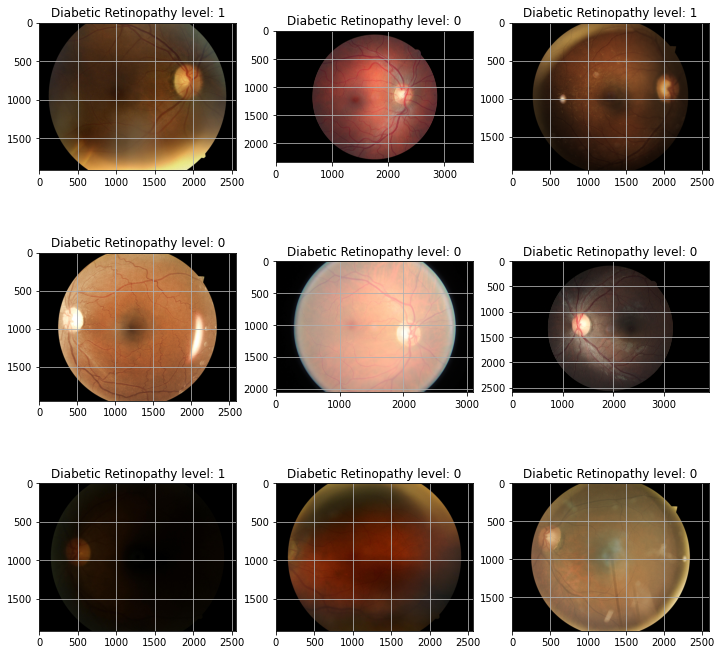

In [6]:
#visualize some random images using 3 x 3 grid images
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.grid('off')

    #Get the random numbers
    index = np.random.randint(df_train.shape[0])
    #load the image
    img = image.load_img('/content/drive/MyDrive/diabetic_retinopathy/dataset/{}.jpeg'.
                                                 format(df_train.iloc[index][0], target_size=(500,500)))
    
    #Get the diabetic retinopathy level 
    plt.title('Diabetic Retinopathy level: {}'.format(df_train.iloc[index][1]))
    plt.imshow(img)
    
plt.show()

In [7]:
#count of disease levels
df_train.groupby(['level']).size()

level
0    1016
1     113
2     230
3      32
4      36
dtype: int64

A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:

* 0 - No DR
* 1 - Mild
* 2 - Moderate
* 3 - Severe
* 4 - Proliferative DR

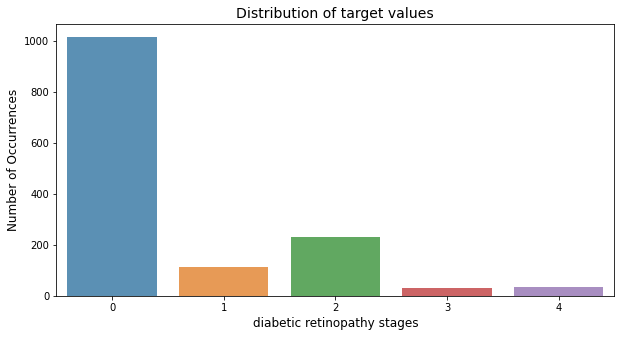

In [8]:
#Target class distribution in dataset
# Plotting a bar graph to count number of each Diabetic Retinopathy level present in dataset
label_count  = df_train['level'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(label_count.index, label_count.values, alpha=0.8)
plt.title('Distribution of target values', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('diabetic retinopathy stages', fontsize=12)
plt.show()

We can see that the dataset is highly **Imbalace.**

In [9]:
#Dividing data into train and test datasetfrom
X_train,X_test = train_test_split(df_train, test_size=0.2, random_state=30)

In [10]:
#reset the index and drop the 1st column for train and test dataset
X_train = X_train.reset_index().drop('index',axis=1)
X_test = X_test.reset_index().drop('index',axis=1)

In [11]:
X_train.shape, X_test.shape

((1141, 2), (286, 2))

In [12]:
#Define image parameters
img_size = 224
img_depth = 3 

### Build batch generator

* **Imbalanced dataset**: It causes the machine learning model to be more **Biased towards majority class**.
* So to deal with Imbalanced dataset we need do **Data Augmentation**.

In [13]:
#Creating function to Extract and Augment the images from Dataset(which is stored in Google Drive)
def batch_generator(df, batchsize=32, train_mode=True):   

    #Image augmentation for imbalanced dataset
    img_generator= ImageDataGenerator(rotation_range=20,
                                                    width_shift_range=0.2,
                                                    height_shift_range=0.2,
                                                    horizontal_flip=True)
    
    
    while True:        
                
        #Generate random numbers to pick images from dataset
        batch_nums = np.random.randint(0,df.shape[0], batchsize)
        
        #Initialize batch images array
        batch_images = np.zeros((batchsize,img_size, img_size,img_depth))
        
        #Initiate batch label array
        batch_labels = np.zeros((batchsize, df.level.nunique()))
        
        for i in range(batchsize):
          try:            
            #Load image
            img = image.load_img('/content/drive/MyDrive/diabetic_retinopathy/dataset/{}.jpeg'.format(X_train.iloc[i][0]), 
                                                                                 target_size=(img_size, img_size))
            #Convert to array
            img = img_to_array(img)
              
            #Applying Data augmentation for only training dataset
            if(train_mode):
                #Apply transform 
                img =  img_generator.random_transform(img)
            
            #Get the class
            img_class = df.loc[batch_nums[i]]['level']
            #Convert class to one hot encoding
            img_class = to_categorical(img_class, num_classes=df.level.nunique())
            
            #Update batch images and class arrays
            batch_images[i] = img
            batch_labels[i] = img_class  
            
            #image scaling
            batch_images = batch_images/255   
           
          except:
            pass 
        
        yield batch_images, batch_labels          

### Model Buliding by using Transfer Learning

1. Using VGG19 model

In [14]:
# Get the vgg16 model from VGG19 library and add preprocessing layer to the front of VGG16
# Here we will be using imagenet weights

vgg19 = VGG19(input_shape=(img_size,img_size,img_depth), weights='imagenet', 
              include_top=False)  #Do not include FC layer at the end

80142336/80134624 [==============================] - 1s 0us/step


In [15]:
#Vgg16 Model Summary before preprocessing
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
# Training only top layers i.e. the layers which we have added in the end
for layer in vgg19.layers:
    layer.trainable = False

#View the output of Pre-trained VGG16 model
vgg19.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [17]:
#get Output layer of Pre-trained model
x = vgg19.output

#Flatten the output to feed to Dense layer
x = Flatten()(x)

x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(200, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

#Add output layer
predictions = Dense(5,activation='softmax')(x)

In [18]:
# Model to be trained using Keras Model class
vgg_model = Model(inputs=vgg19.input, #Pre-trained model input as input layer
                                    outputs=predictions) #Output layer added


#Compiling the model with loss, optimizer chosen and accuracy as metrics
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#Vgg16 Model Summary after preprocessing
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
#Create train and test generator
batchsize = 36
train_generator = batch_generator(X_train, batchsize=batchsize) #batchsize can be changed
test_generator = batch_generator(X_test, batchsize=batchsize, train_mode=False)

In [20]:
#add checkpoint
file_path = '/content/drive/MyDrive/diabetic_retinopathy/Checkpoints/Vgg19_checkpoints/weights-improvement-{epoch:02d}--{val_accuracy:.2f}.hdf5'
vgg_checkpoint = ModelCheckpoint(filepath=file_path, monitor='val_accuracy', 
                                       verbose=1, save_best_only=True, mode='max')

In [21]:
# Training the model for 20 epochs
vgg19_model = vgg_model.fit_generator(train_generator, 
                          epochs=20,
                          steps_per_epoch= X_train.shape[0]//batchsize,
                          validation_data=test_generator,
                          validation_steps = X_test.shape[0]//batchsize,
                          callbacks = vgg_checkpoint)

Epoch 1/20
31/31 [==============================] - 205s 6s/step - loss: 2.1727 - accuracy: 0.2581 - val_loss: 1.4414 - val_accuracy: 0.6706

Epoch 00001: val_accuracy improved from -inf to 0.67063, saving model to /content/drive/MyDrive/diabetic_retinopathy/Checkpoints/Vgg19_checkpoints/weights-improvement-01--0.67.hdf5
Epoch 2/20
31/31 [==============================] - 174s 6s/step - loss: 1.9148 - accuracy: 0.3530 - val_loss: 1.1937 - val_accuracy: 0.7381

Epoch 00002: val_accuracy improved from 0.67063 to 0.73810, saving model to /content/drive/MyDrive/diabetic_retinopathy/Checkpoints/Vgg19_checkpoints/weights-improvement-02--0.74.hdf5
Epoch 3/20
31/31 [==============================] - 173s 6s/step - loss: 1.5459 - accuracy: 0.4633 - val_loss: 1.1107 - val_accuracy: 0.7222

Epoch 00003: val_accuracy did not improve from 0.73810
Epoch 4/20
31/31 [==============================] - 173s 6s/step - loss: 1.3923 - accuracy: 0.5529 - val_loss: 1.0046 - val_accuracy: 0.7460

Epoch 00004:

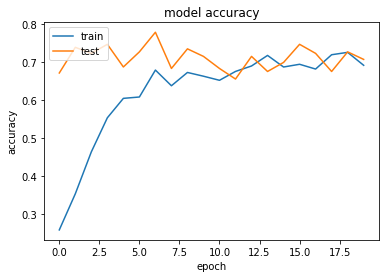

In [22]:
# summarize history for accuracy
plt.plot(vgg19_model.history['accuracy'])
plt.plot(vgg19_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
vgg19_model.history['accuracy']

[0.25806450843811035,
 0.35304659605026245,
 0.4632616341114044,
 0.5528674125671387,
 0.6039426326751709,
 0.6075268983840942,
 0.6783154010772705,
 0.6370967626571655,
 0.6720430254936218,
 0.6621863842010498,
 0.6514337062835693,
 0.6747311949729919,
 0.689068078994751,
 0.7168458700180054,
 0.6863799095153809,
 0.6935483813285828,
 0.6810035705566406,
 0.718638002872467,
 0.7249103784561157,
 0.6908602118492126]

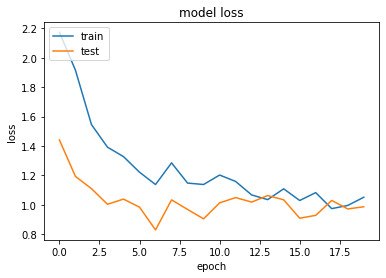

In [24]:
# summarize history for loss
plt.plot(vgg19_model.history['loss'])
plt.plot(vgg19_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
#Save the model
vgg_model.save('/content/drive/MyDrive/diabetic_retinopathy/diabetic_retinopathy_vgg19.h5')

2. Using ResNet50 model

In [26]:
# Get the vgg16 model from VGG19 library and add preprocessing layer to the front of VGG16
# Here we will be using imagenet weights
res50 = ResNet50(input_shape=(img_size,img_size,img_depth), weights='imagenet', 
              include_top=False)  #Do not include FC layer at the end

94773248/94765736 [==============================] - 1s 0us/step


In [27]:
#Resnet50 Model Summary before preprocessing
res50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [28]:
# Training only top layers i.e. the layers which we have added in the end
for layer in res50.layers:
    layer.trainable = False

#View the output of Pre-trained Resnet50 model
res50.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [39]:
k.clear_session()
#get Output layer of Pre0trained model
x = res50.output

#Flatten the output to feed to Dense layer
x = Flatten()(x)

#Add one Dense layer
x = Dense(200, activation='relu')(x)

#Add output layer
prediction = Dense(5,activation='softmax')(x)

In [40]:
#Using Keras Model class
res_model = Model(inputs=res50.input, #Pre-trained model input as input layer
                                    outputs=prediction) #Output layer added

#Compiling the model with loss, optimizer chosen and accuracy as metrics
res_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#res50 Model Summary after preprocessing
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [41]:
#Create train and test generator
batchsize = 36
train_generator = batch_generator(X_train, batchsize=batchsize) #batchsize can be changed
test_generator = batch_generator(X_test, batchsize=batchsize, train_mode=False)

In [42]:
#add checkpoint
file_path = '/content/drive/MyDrive/diabetic_retinopathy/Checkpoints/Res_checkpoints/weights-improvement-{epoch:02d}--{val_accuracy:.2f}.hdf5'
res_checkpoint = ModelCheckpoint(filepath=file_path, monitor='val_accuracy', 
                                       verbose=1, save_best_only=True, mode='max')

In [43]:
# Training the model for 15 epochs
res50_model = res_model.fit_generator(train_generator, 
                          epochs=15,
                          steps_per_epoch= X_train.shape[0]//batchsize,
                          validation_data=test_generator,
                          validation_steps = X_test.shape[0]//batchsize,
                          callbacks = res_checkpoint)

Epoch 1/15
31/31 [==============================] - 177s 6s/step - loss: 8.0863 - accuracy: 0.5341 - val_loss: 5.3897 - val_accuracy: 0.0476

Epoch 00001: val_accuracy improved from -inf to 0.04762, saving model to /content/drive/MyDrive/diabetic_retinopathy/Checkpoints/Res_checkpoints/weights-improvement-01--0.05.hdf5
Epoch 2/15
31/31 [==============================] - 171s 6s/step - loss: 1.9442 - accuracy: 0.6470 - val_loss: 1.0975 - val_accuracy: 0.7421

Epoch 00002: val_accuracy improved from 0.04762 to 0.74206, saving model to /content/drive/MyDrive/diabetic_retinopathy/Checkpoints/Res_checkpoints/weights-improvement-02--0.74.hdf5
Epoch 3/15
31/31 [==============================] - 172s 6s/step - loss: 1.0355 - accuracy: 0.6819 - val_loss: 1.0326 - val_accuracy: 0.7143

Epoch 00003: val_accuracy did not improve from 0.74206
Epoch 4/15
31/31 [==============================] - 171s 6s/step - loss: 1.2519 - accuracy: 0.6030 - val_loss: 1.0661 - val_accuracy: 0.6905

Epoch 00004: val

In [44]:
# list all data in history
print(res50_model.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


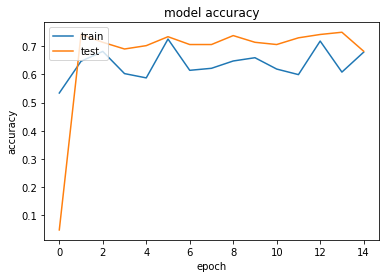

In [45]:
# summarize history for accuracy
plt.plot(res50_model.history['accuracy'])
plt.plot(res50_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
res50_model.history['accuracy']

[0.5340501666069031,
 0.6469534039497375,
 0.6818996667861938,
 0.6030465960502625,
 0.5878136157989502,
 0.725806474685669,
 0.6146953701972961,
 0.6218637824058533,
 0.647849440574646,
 0.6594982147216797,
 0.6191756129264832,
 0.5994623899459839,
 0.718638002872467,
 0.6084229350090027,
 0.6792114973068237]

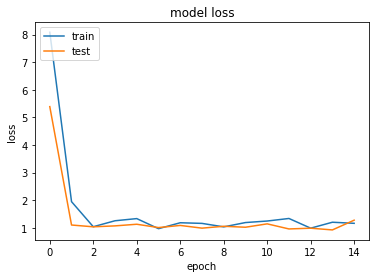

In [47]:
# summarize history for loss
plt.plot(res50_model.history['loss'])
plt.plot(res50_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
#Save the model
res_model.save('/content/drive/MyDrive/diabetic_retinopathy/diabetic_retinopathy_Resnet50.h5')

## Conclusion
  * **Deep Learning** techniques would generally give better performance and results for **large data sets**. 
  * Here we applied **Data Augmentation** to address the **Imbalanced dataset**.
  * Used Python **Generator-Function** for batch generator to boost the model performance.
  * Sinse we have large dataset with complex eye images using **TransferLearning** is the better option to get good results.
  * By comparing both results of VGG19 and ResNet50 models, **VGG19 performing well with highest validation accuracy of 77.7%.** 